# Predicting base metal futures returns with economic data

This notebook serves as an illustration of the points discussed in the post ["Predicting base metal futures returns with economic data"](https://research.macrosynergy.com/predicting-base-metal-futures-returns-with-economic-data/) available on the Macrosynergy website. 

Unlike other derivatives markets, for commodity futures, there is a direct relation between economic activity and demand for the underlying assets. Data on industrial production and inventory build-ups indicate whether recent past demand for industrial commodities has been excessive or repressed. This helps to spot temporary price exaggerations. Moreover, changes in manufacturing sentiment should help predict turning points in demand. Empirical evidence based on real-time U.S. data and base metal futures returns confirms these effects. Simple strategies based on a composite score of inventory dynamics, past industry growth, and industry mood swings would have consistently added value to a commodities portfolio over the past 28 years, without adding aggregate commodity exposure or correlation with the broader (equity) market.

This notebook provides the essential code required to replicate the analysis discussed in the post.  

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages used throughout the analysis. 

- Transformations and Checks: In this part, the notebook performs calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including the normalization of feature variables using z-score or building a simple linear composite indicator for commodities futures returns.

- Value Checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. This section involves backtesting a few simple but powerful trading strategies targeting the relative returns of each metal contract versus a basket of non-industrial commodity contracts. This type of return is chosen to disentangle the specific performance of base metals contracts from common factors that drive all commodity returns and to avoid aggregate exposure to (and risk premia of) the broad commodity market.

It's important to note that while the notebook covers a selection of indicators and strategies used for the post's main findings, there are countless other possible indicators and approaches that users can explore. Users can modify the code to test different hypotheses and strategies based on their own research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
# Run only if needed!
"""! pip install macrosynergy --upgrade"""

'! pip install macrosynergy --upgrade'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md)

In [3]:
# Manufacturing surveys and production

dict_ms = {
    "mt": ["ISMMANU_SA_3MMA", "PHILMANU_SA_3MMA", "IP_SA_P3M3ML3AR"],
    "st": [
        "ISMMANU_SA_D3M3ML3",
        "PHILMANU_SA_D3M3ML3",
        "IP_SA_P1M1ML12_3MMA",
    ],
}

# Orders and inventories
dict_oi = {
    "mt": [
        "DGORDERS_SA_P1M1ML12_3MMA",
        "BINVENTORIES_SA_P1M1ML12_3MMA",
    ],
    "st": [
        "DGORDERS_SA_P3M3ML3AR",  # "DGORDERSXD_SA_P3M3ML3AR",
        "BINVENTORIES_SA_P3M3ML3AR",
    ],
}

# Tickers

lds = [dict_ms, dict_oi]


xcats_mt = [x for d in lds for x in d["mt"]]
xcats_st = [x for d in lds for x in d["st"]]
# xcats_eq = ["EQXR_NSA"]  # equity returns (used as correlation benchmark)

xcats_us = xcats_mt + xcats_st  # + xcats_eq

tix_us = ["USD_" + x for x in xcats_us]

In [4]:
dict_co = {
    "FUE": [
        "BRT",
        "WTI",
        "NGS",
        "GSO",
        "HOL",
    ],  # The energy commodity group. See Appendix 1 https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Commodity%20future%20returns.php
    "BAM": ["ALM", "CPR", "LED", "NIC", "TIN", "ZNC"],  # The base metals group
    "PRM": ["GLD", "SIV", "PAL", "PLT"],  # The precious metals group
    "CBC": [
        "COR",
        "WHT",
        "SOY",
        "CTN",
    ],  # The agricultural commodity group (corn, wheat, soybeans, cotton)
    "OAS": [
        "CFE",
        "SGR",
        "NJO",
        "CLB",
    ],  # The agricultural commodity group (cofee, sugar, orange juice, lumber)
    "LIV": ["CAT", "HOG"],  # The (U.S.) livestock commodity group
}

cids_co = [c for lc in dict_co.values() for c in lc]
cids_ind = dict_co["BAM"]

xcats_co = ["COXR_VT10", "COXR_NSA"]

tix_co = [c + "_" + x for c in cids_co for x in xcats_co]

The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/), or [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected). The notebook uses categories that are specific to the United States. The market-relevant dataset in the U.S. is broader, timelier, and - for the most part - of better quality than on average in other countries. Also, U.S. data have on average greater global importance than those of other countries due to the dominant role of the USD for global financial markets. For tickers used in this notebook see [U.S. special data](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/U.S.%20special%20data.php), [Industrial production trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Industrial%20production%20trends.php), and [Commodity future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Commodity%20future%20returns.php).

In [5]:
#  Download series from J.P. Morgan DataQuery by tickers

start_date = "1990-01-01"
end_date = "2023-07-01"

tickers = tix_us + tix_co
print(f"Maximum number of tickers is {len(tickers)}")

# Retrieve credentials
client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date=start_date,
        suppress_warning=True,
        metrics=["all"],
        show_progress=True,
    )

Maximum number of tickers is 60
Timestamp UTC:  2024-03-21 14:59:26
Connection successful!


Requesting data: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Some dates are missing from the downloaded data. 
2 out of 8931 dates are missing.


In [6]:
dfx = df.copy().sort_values(["cid", "xcat", "real_date"])

### Availability

Prior to commencing any analysis, it is crucial to evaluate the accessibility of data. This evaluation serves several purposes, including the identification of potential data gaps or constraints within the dataset. Such gaps can significantly influence the trustworthiness and accuracy of the analysis. Moreover, it aids in verifying that an ample number of observations are accessible for each chosen category and cross-section. Additionally, it assists in establishing the suitable timeframes for conducting the analysis.

In [7]:
msm.missing_in_df(df, xcats=xcats_us, cids=["USD"])

Missing xcats across df:  []
Missing cids for BINVENTORIES_SA_P1M1ML12_3MMA:  []
Missing cids for BINVENTORIES_SA_P3M3ML3AR:  []
Missing cids for DGORDERS_SA_P1M1ML12_3MMA:  []
Missing cids for DGORDERS_SA_P3M3ML3AR:  []
Missing cids for IP_SA_P1M1ML12_3MMA:  []
Missing cids for IP_SA_P3M3ML3AR:  []
Missing cids for ISMMANU_SA_3MMA:  []
Missing cids for ISMMANU_SA_D3M3ML3:  []
Missing cids for PHILMANU_SA_3MMA:  []
Missing cids for PHILMANU_SA_D3M3ML3:  []


In [8]:
msm.missing_in_df(df, xcats=xcats_co, cids=cids_co)

Missing xcats across df:  []
Missing cids for COXR_NSA:  []
Missing cids for COXR_VT10:  []


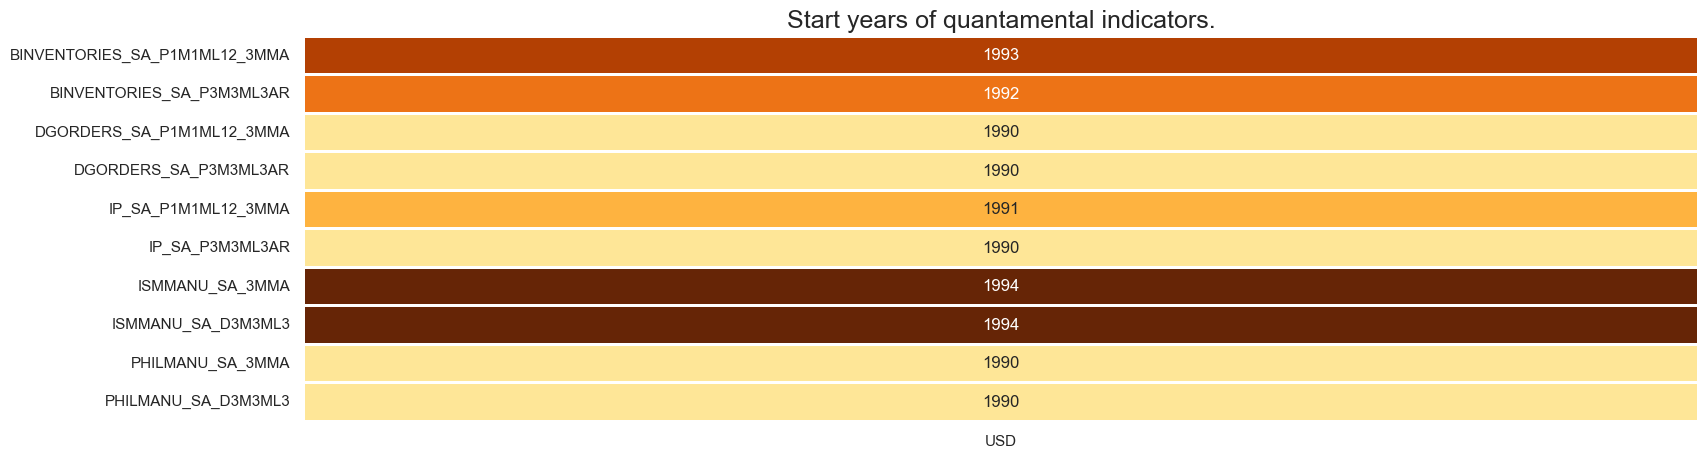

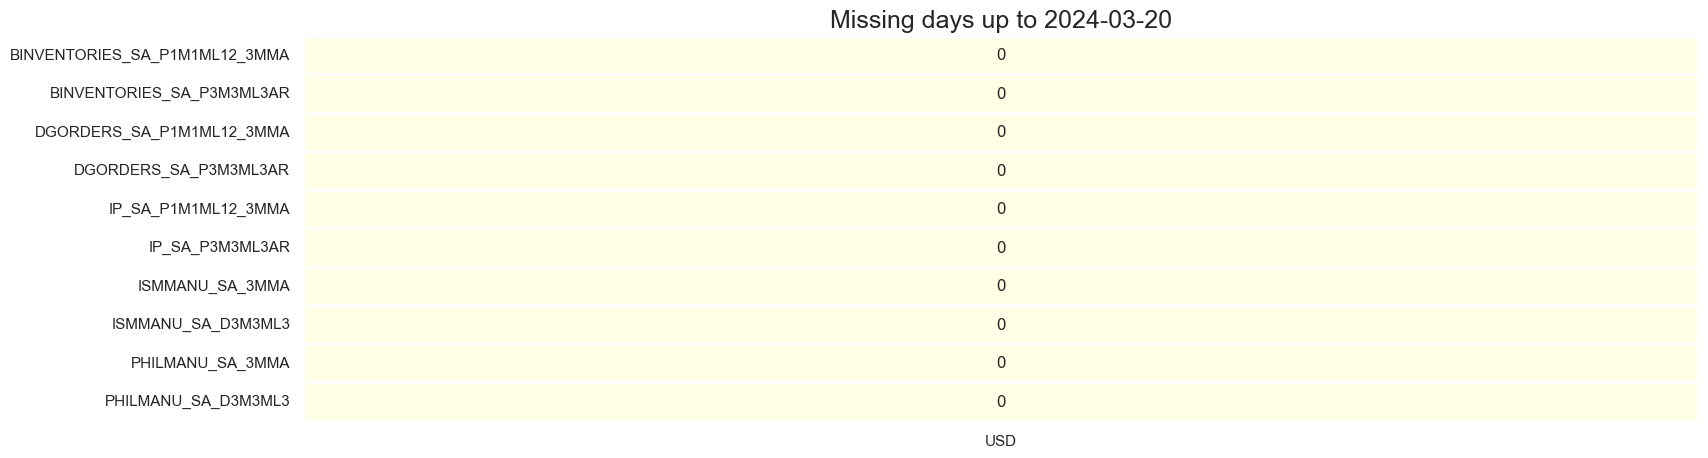

In [9]:
msm.check_availability(df, xcats=xcats_us, cids=["USD"])

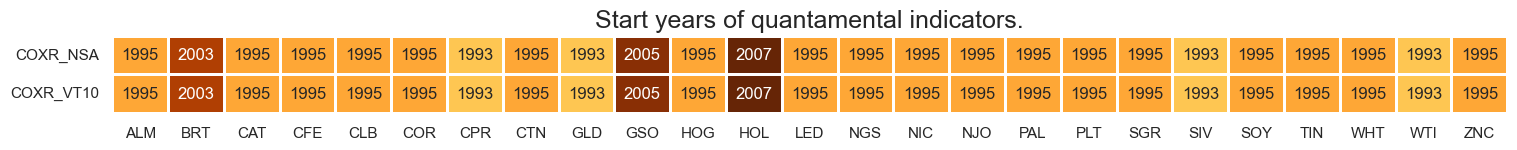

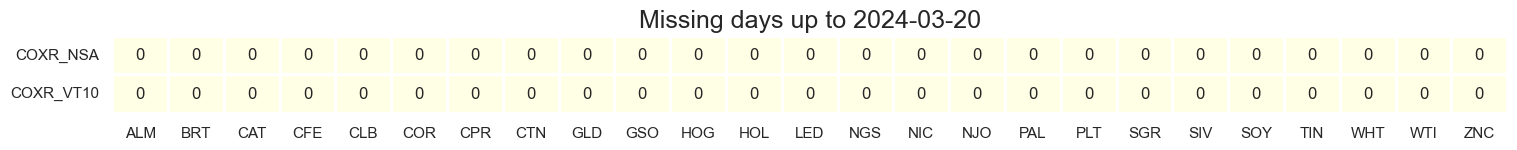

In [10]:
msm.check_availability(df, xcats=xcats_co, cids=cids_co)

### Blacklist dictionaries

To ensure accurate calculations and analysis, it is imperative to exclude the period of trading halt. In March 2022, the LME Nickel Official Prices experienced disruption events, rendering them as disrupted Official Prices. Consequently, we must omit the data from March 2022 when performing calculations and analyses. For more details on these disruption events, you can refer to the [LME Nickel MASP Calculation announcement](https://www.lme.com/en/market-data/disruption-events/lme-nickel-masp-calculation-for-march-2022), therefore we exclude the March 2022 from calculations disruption events. The chart below illustrates this period of disruption events: 

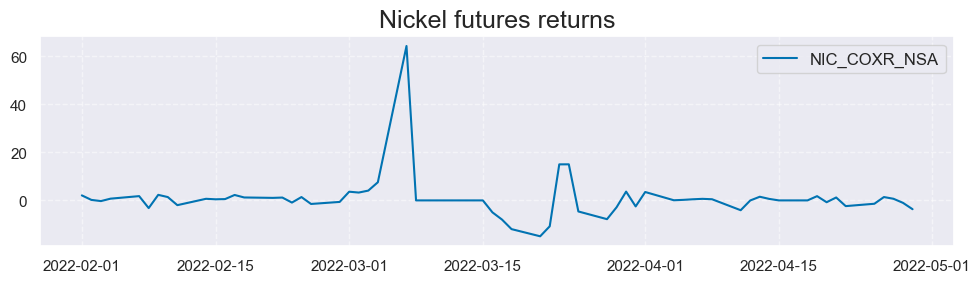

In [11]:
msp.view_timelines(
    dfx,
    xcats=[
        "COXR_NSA",
    ],
    cids=["NIC"],
    size=(10, 3),
    cumsum=False,
    start="2022-02-01",
    end="2022-05-01",
    title="Nickel futures returns",
)

coblack = {
    "NIC": ("2022-03-01", "2022-04-01"),  # exclude month of trading halt
}

## Transformations and checks

### Features

Normalizing values across different categories is a common practice in macroeconomics. This is particularly important when summing or averaging categories with different units and time series properties. Using `macrosynergy's` custom function [`make_zn_scores()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#normalize-panels-with-make-zn-scores) we normalize the selected scores (Business surveys, and Orders and Inventories) around neutral value (median), using only past information. Re-estimation is done quarterly, and we use a minimum of 5 years data. We protect against outliers using three standard deviations as threshold. The normalized indicators receive postfix `_ZN`

In [12]:
xcatx_ind = dict_ms["mt"] + dict_ms["st"] + dict_oi["mt"] + dict_oi["st"]
cidx = ["USD"]
xcatx = xcatx_ind


for xc in xcatx_ind:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=["USD"],
        sequential=True,
        min_obs=5 * 261,
        neutral="median",
        est_freq="q",
        thresh=3,
    )
    dfx = msm.update_df(dfx, dfa)

xcatx_indz = [xc + "ZN" for xc in xcatx_ind]

In the below cell we use 1-year moving average of selectd z-score giving them postfix `_ZYMA`. The list of z-scores are collected in the list `xcatx_yma` and include 'ISMMANU_SA_ZYMA' (ISM manufacturing survey),  'PHILMANU_SA_ZYMA' (Philadelphia manufacturing survey), 'IP_SA_P1M1ML12_ZYMA' (Industrial production trend),  and 'DGORDERS_SA_P1M1ML12_ZYMA' ( Durable goods orders). 

In [13]:
cidx = ["USD"]
xcatx_sio = [
    "ISMMANU_SA_3MMA",
    "PHILMANU_SA_3MMA",
    "IP_SA_P1M1ML12_3MMA",
    "DGORDERS_SA_P1M1ML12_3MMA",
]

calcs = []
for xc in xcatx_sio:
    calc = f"{xc}x = {xc}ZN.rolling(window=260).mean() "
    calc = calc.replace("3MMAx", "ZYMA")
    calcs += [calc]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx, blacklist=coblack)
dfx = msm.update_df(dfx, dfa)

xcatx_yma = list(dfa["xcat"].unique())

Here we simply plot the selected z-scores over time:

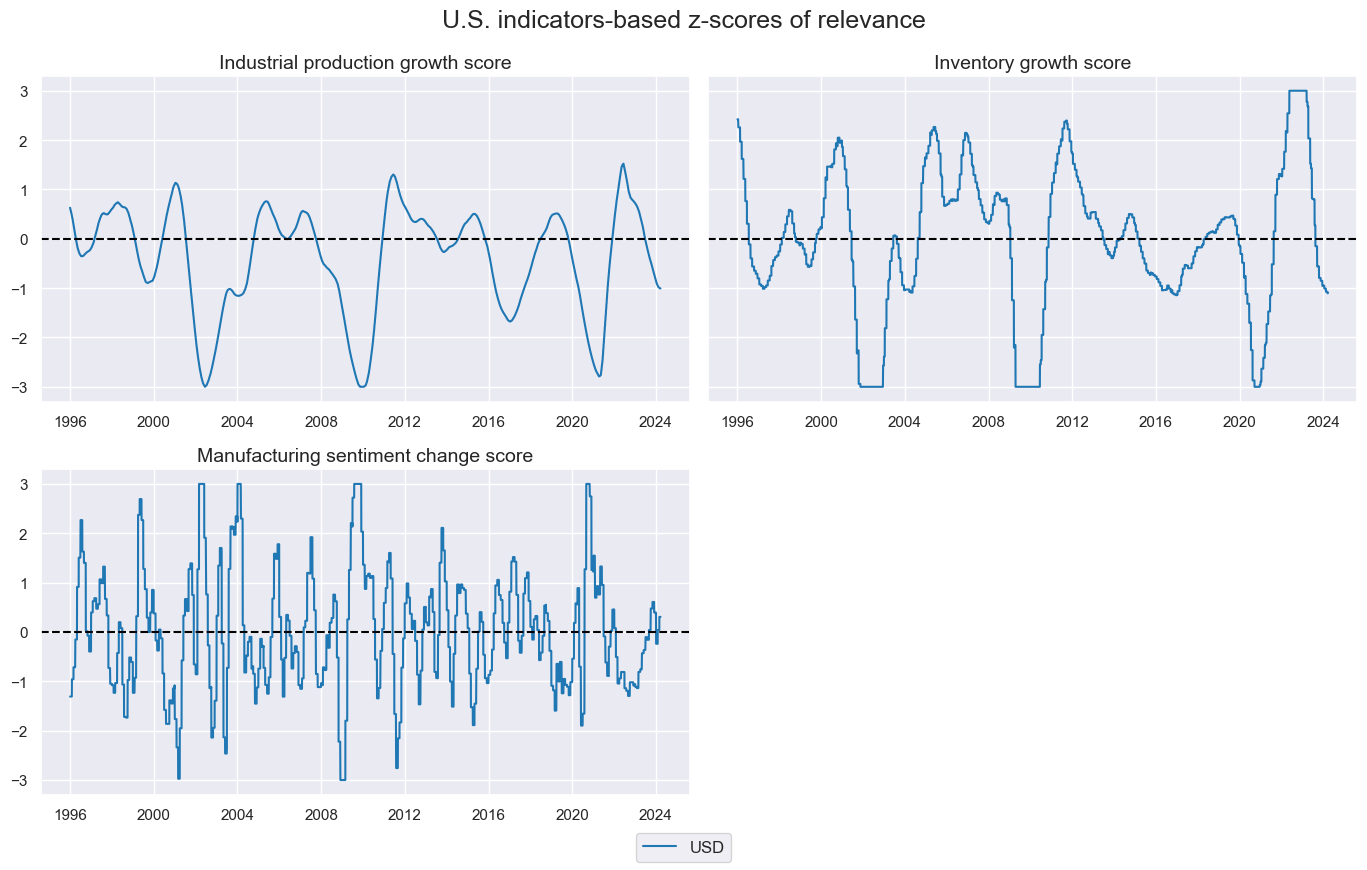

In [14]:
cidx = "USD"

msp.view_timelines(
    dfx,
    xcats=[
        "BINVENTORIES_SA_P1M1ML12_3MMAZN",  # representation of the recent stock building
        "IP_SA_P1M1ML12_ZYMA",  # past cyclical state of the industry sector
        "ISMMANU_SA_D3M3ML3ZN",  # direction and magnitude of sentiment changes
    ],
    xcat_grid=True,
    xcat_labels=[
        "Inventory growth score",
        "Industrial production growth score",
        "Manufacturing sentiment change score",
    ],
    cids=cidx,
    ncol=2,
    cumsum=False,
    start="1996-01-01",
    same_y=True,
    all_xticks=True,
    title="U.S. indicators-based z-scores of relevance",
)

### Targets

Commodity basket returns are calculated as equally weighted vol target-adjusted positions with help `macrosynergy` [`basket` class](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#generate-returns-and-carry-of-a-group-of-contracts-with-basket)

In [15]:
dict_x = dict_co.copy()
dict_x["FUX"] = list(
    set(dict_x["FUE"]) - set(["WTI", "BRT"])
)  # precious metals ex gold
dict_x["NIN"] = ["PRM", "CBC", "OAS", "LIV", "FUX"]  # non-industrials
dict_x["ALL"] = cids_co

for key, values in dict_x.items():
    coms = [v + "_" for v in values]
    bsk = msp.Basket(dfx, contracts=coms, ret="COXR_VT10", blacklist=coblack)
    bsk.make_basket(weight_meth="equal", basket_name=key)
    dfa = bsk.return_basket()
    dfx = msm.update_df(dfx, dfa)

Cross-group specific long-term return performance has diverged substantially overtime. The plot below simply shows vol targeted future returns for chosen commodities groups (Energy, base metals, precious metals, agricultural commodities (2 groups), and livestock) and their equally weighted average.

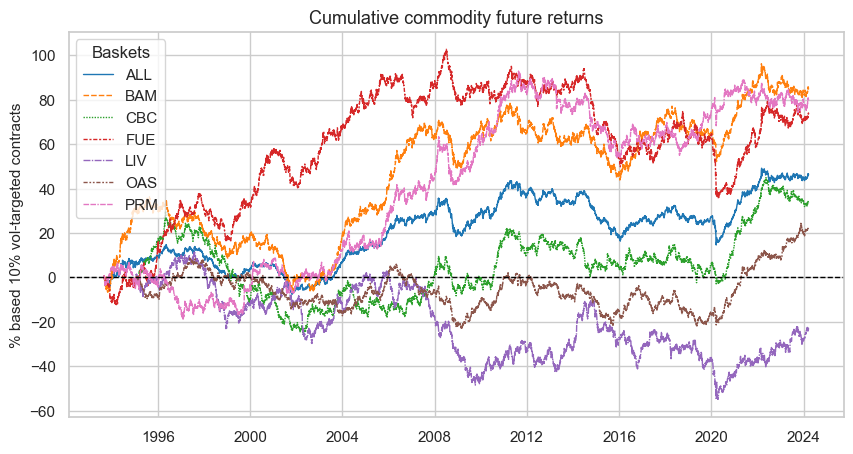

In [16]:
cidx = [key for key in dict_co.keys()] + ["ALL"]

filt1 = dfx["xcat"] == "COXR_VT10"
filt2 = dfx["cid"].isin(cidx)
filt3 = dfx["real_date"] > "1995-01-01"
dfdx = dfx[filt1 & filt2]
dfw = dfdx.pivot(index=["real_date"], columns="cid", values="value").cumsum()

colors = "tab10"  # choose color palette
sns.set_theme(style="whitegrid", rc={"figure.figsize": (10, 5)})  #  choose appearance
ax = sns.lineplot(
    data=dfw, estimator=None, palette=colors, linewidth=1
)  # simply pass data frame with time scale to method

plt.axhline(y=0, color="black", linestyle="--", lw=1)  # horizontal line at zero
plt.title("Cumulative commodity future returns", fontsize=13)  # set title
plt.xlabel("")  # set x-axis label
plt.ylabel("% based 10% vol-targeted contracts", fontsize=11)  # set y-axis label

leg = ax.axes.get_legend()  # add legend box explicitly for control
leg.set_title("Baskets")  # set title of legend box

plt.show()

The below panel shows cumulative outright and relative base metal future returns. The different metals have their own long-term patterns, but also much communal short-term variation and a common “super-cycle” in the late 1990s and 2000s.

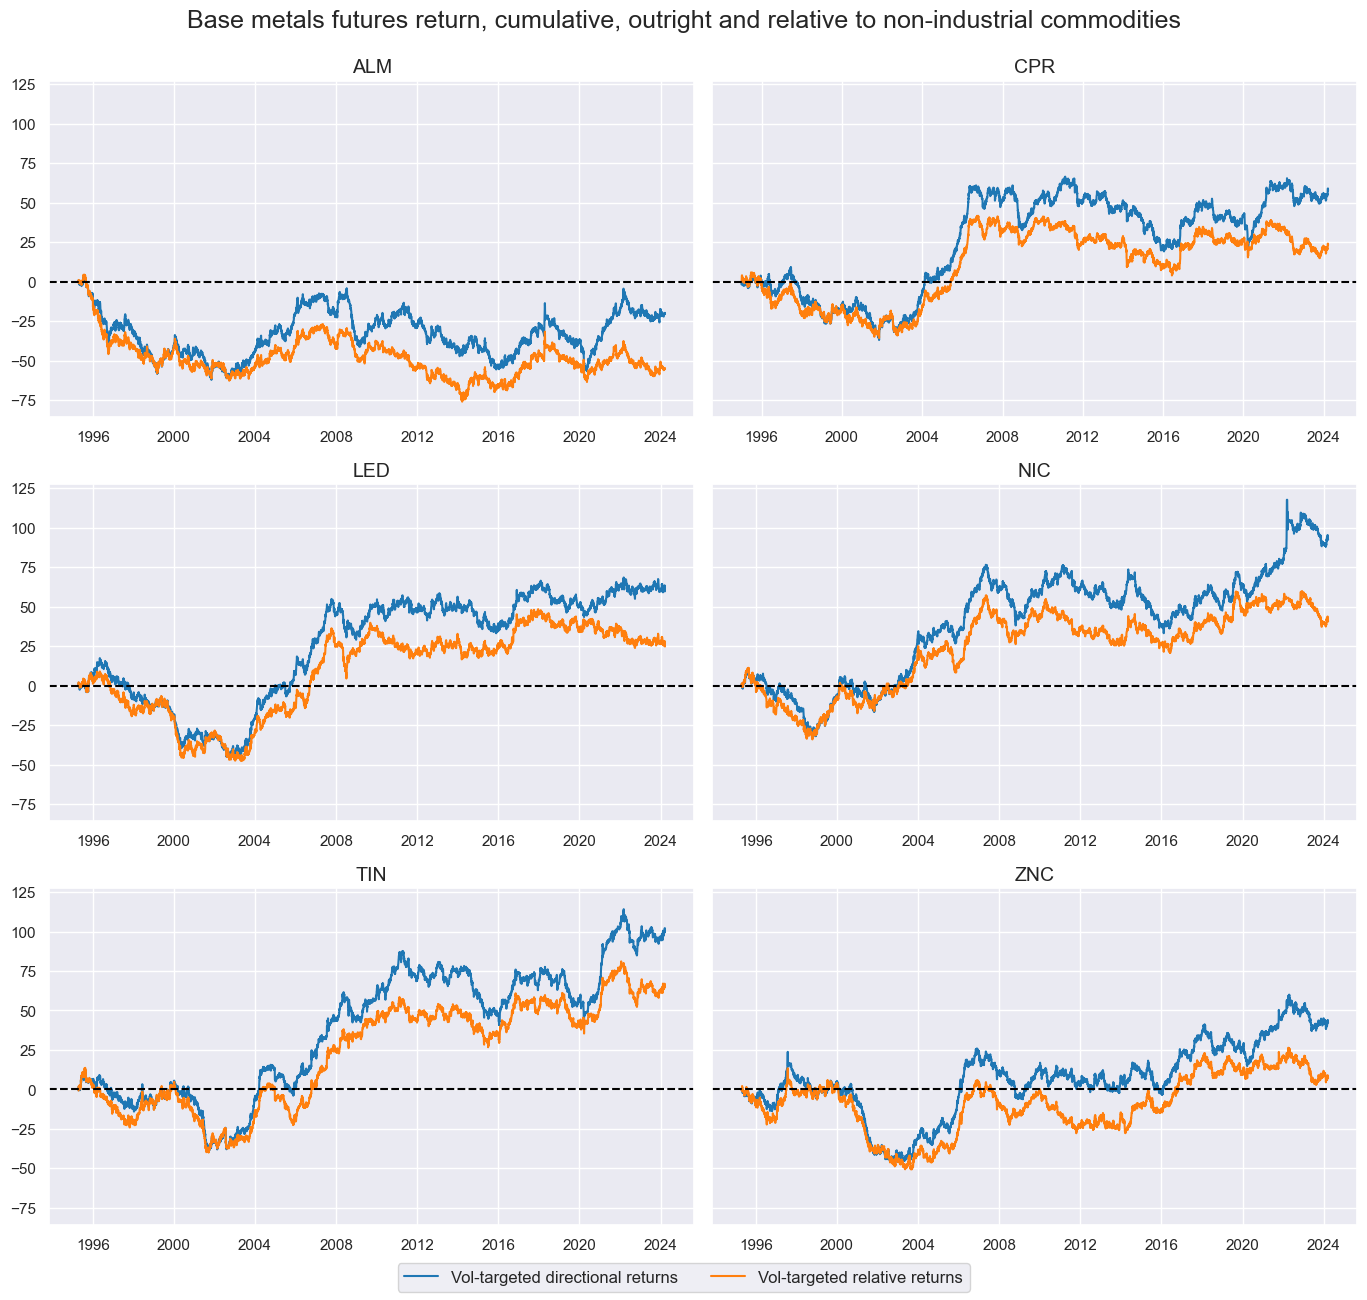

In [17]:
cidx = cids_ind
calcs = ["COXR_VT10vNIN = COXR_VT10 - iNIN_COXR_VT10"]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx, blacklist=coblack)
dfx = msm.update_df(dfx, dfa)

xcatx = ["COXR_VT10", "COXR_VT10vNIN"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    xcat_labels=["Vol-targeted directional returns", "Vol-targeted relative returns"],
    cids=cidx,
    ncol=2,
    cumsum=True,
    start="1995-01-01",
    same_y=True,
    all_xticks=True,
    title="Base metals futures return, cumulative, outright and relative to non-industrial commodities",
)

### Data selection and composite scores

In [18]:
# Pick the commodity returns

filt_cat = dfx["xcat"].isin(["COXR_VT10", "COXR_VT10vNIN", "COXR_NSA"])
filt_cid = dfx["cid"].isin(cids_ind)
dfx_ind = dfx[filt_cat & filt_cid]

# Pick and rename the U.S. indicators

xcatx = xcatx_indz + xcatx_yma
filt_cat = dfx["xcat"].isin(xcatx)
filt_cid = dfx["cid"] == "USD"

dfx_usd = dfx[filt_cat & filt_cid]
for cid in cids_ind:
    dfx_usd["cid"] = cid
    dfx_ind = msm.update_df(dfx_ind, dfx_usd)

Composite scores

In the following code block, we compute straightforward averages of key U.S. economic indicators and incorporate them into the dataframe. These composite indicatpors will be used as signals for naive PnL calculations later in the noteboik. Specifically:

`IOMT_ZC` represents the mean of two indicators: Business inventories, 3-month moving average, and the Industrial production trend.

`IOST_ZC` signifies the mean of Business inventories and Durable goods orders.

`TURN_ZC` is determined as half of the difference between the ISM manufacturing survey and the previously calculated IOMT_ZC.

`TURN_ZCX` corresponds to one-third of the difference between the ISM manufacturing survey and the combined sum of the previously calculated IOMT_ZC and IOST_ZC.

In [19]:
cidx = cids_ind
calcs = [
    "IOMT_ZC = 1/2 * ( BINVENTORIES_SA_P1M1ML12_3MMAZN  + IP_SA_P1M1ML12_ZYMA )",
    "IOST_ZC = 1/2 * ( BINVENTORIES_SA_P3M3ML3ARZN  + DGORDERS_SA_P3M3ML3ARZN )",
    "TURN_ZC = 1/2 * ( ISMMANU_SA_D3M3ML3ZN - IOMT_ZC )",
    "TURN_ZCX = 1/3 * ( ISMMANU_SA_D3M3ML3ZN - IOMT_ZC - IOST_ZC ) ",
]

dfa = msp.panel_calculator(dfx_ind, calcs=calcs, cids=cidx)
dfx_ind = msm.update_df(dfx_ind, dfa)

## Value checks

In this part of the analysis, the notebook calculates the naive PnLs (Profit and Loss) testing predictive power of sentiment changes. The PnLs are calculated based on simple trading strategies that utilize the created composite score as signals (no regression analysis is involved). The strategies involve going long (buying) or short (selling) on  Equity positions based purely on the direction of the excess inflation signals.

To evaluate the performance of these strategies, the notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between the strategy returns and the actual returns. Positive correlations indicate that the strategy moves in the same direction as the market, while negative correlations indicate an opposite movement.

- Accuracy Metrics: These metrics assess the accuracy of composite score strategies in predicting market movements. Common accuracy metrics include accuracy rate, balanced accuracy, precision etc.

- Performance Ratios: Various performance ratios, such as Sharpe ratio, Sortino ratio, Max draws etc.

The notebook compares the performance of these simple sentiment changes strategies with the long-only performance of commodity futures. 

It's important to note that the analysis deliberately disregards transaction costs and risk management considerations. This is done to provide a more straightforward comparison of the strategies' raw performance without the additional complexity introduced by transaction costs and risk management, which can vary based on trading size, institutional rules, and regulations.

The analysis in the post and sample code in the notebook is a proof of concept only, using the simplest design.

### Medium-term excess demand

#### Specification notebook

As mentioned in the beginning of the notebook and in the post itself, the hypothesis is that both past inventory growth and past industrial production growth are negatively correlated with future monthly or quarterly base metal excess returns (relative to non-industrial commodity returns). Here we empirically test this hypothesis.

In [20]:
dict_ind_mt = {
    "df": dfx_ind,
    "sig": "BINVENTORIES_SA_P1M1ML12_3MMAZN",
    "rivs": [
        "IP_SA_P1M1ML12_ZYMA",
        "DGORDERS_SA_P1M1ML12_ZYMA",
        #   "DGORDERSXD_SA_P1M1ML12_ZYMA",
    ],
    "targ": "COXR_VT10vNIN",
    "cidx": cids_ind,
    "black": coblack,
    "srr": None,
    "pnls": None,
}

#### Correlation and accuracy

As expected, past inventory and industrial production growth have negatively predicted future monthly or quarterly base metal excess returns (relative to non-industrial commodity returns) from 1995 to 2023.

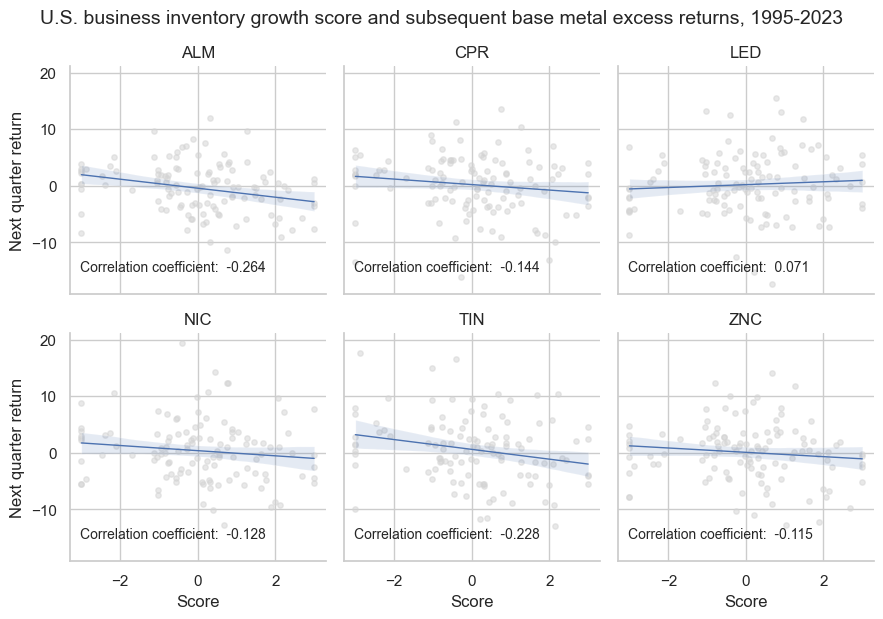

In [21]:
dix = dict_ind_mt

df = dix["df"]
sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    df,
    xcats=[sig, targ],
    xcat1_chg=None,
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="1995-01-01",
    blacklist=blax,
    xcat_trims=[10000, 40],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    separator="cids",
    xlab="Score",
    ylab="Next quarter return",
    title="U.S. business inventory growth score and subsequent base metal excess returns, 1995-2023",
    title_adj=1.03,
    size=(10, 4),
)

Across contracts, negative correlations prevailed across 5 out of 6 sections, with the lead being the odd metal out. The strongest negative forward return correlations were recorded for aluminum and tin with over 20% quarterly forward correlation coefficients.



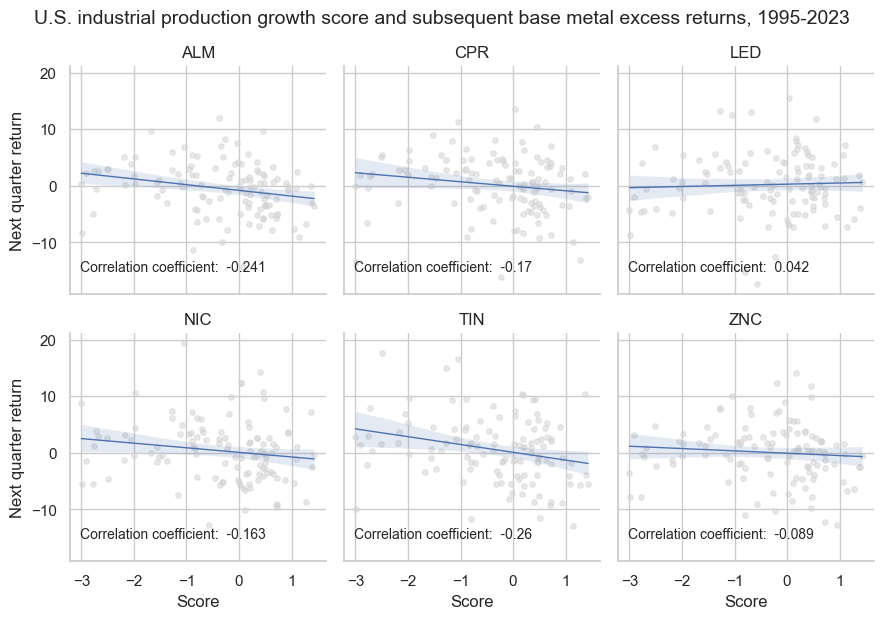

In [22]:
dix = dict_ind_mt

df = dix["df"]
sig = dix["rivs"][0]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    df,
    xcats=[sig, targ],
    xcat1_chg=None,
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="1995-01-01",
    blacklist=blax,
    xcat_trims=[10000, 40],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    separator="cids",
    xlab="Score",
    ylab="Next quarter return",
    title="U.S. industrial production growth score and subsequent base metal excess returns, 1995-2023",
    title_adj=1.03,
    size=(12, 6),
)

### Composite excess demand & mood swing score

#### Specification notebook


We compute stylized Profit and Loss (PnL), which represents dollar-based gains or losses after accounting for funding costs, using established methodologies as described in previous posts and for the aforementioned strategies. Initially, we create a dictionary wherein the primary signal, denoted as TURN_ZC, is calculated as half of the disparity between the ISM manufacturing survey and the average of Business inventories and Durable goods orders. The objective is to assess the relative returns of base metal futures, termed COXR_VT10vNIN, which measure the performance of each metal contract in relation to a basket of non-industrial commodity contracts.

In [23]:
dict_mss = {
    "df": dfx_ind,
    "sig": "TURN_ZC",
    "rivs": [
        "TURN_ZCX",
    ],
    "targ": "COXR_VT10vNIN",
    "cidx": cids_ind,
    "black": coblack,
    "srr": None,
    "pnls": None,
}

#### Correlation and accuracy

As first step we check correlation and signal accuracy of the earlier defined main and alternative signals and the subsequent returns on monthly basis. The relationship is positive for 5 out of 6 contracts.

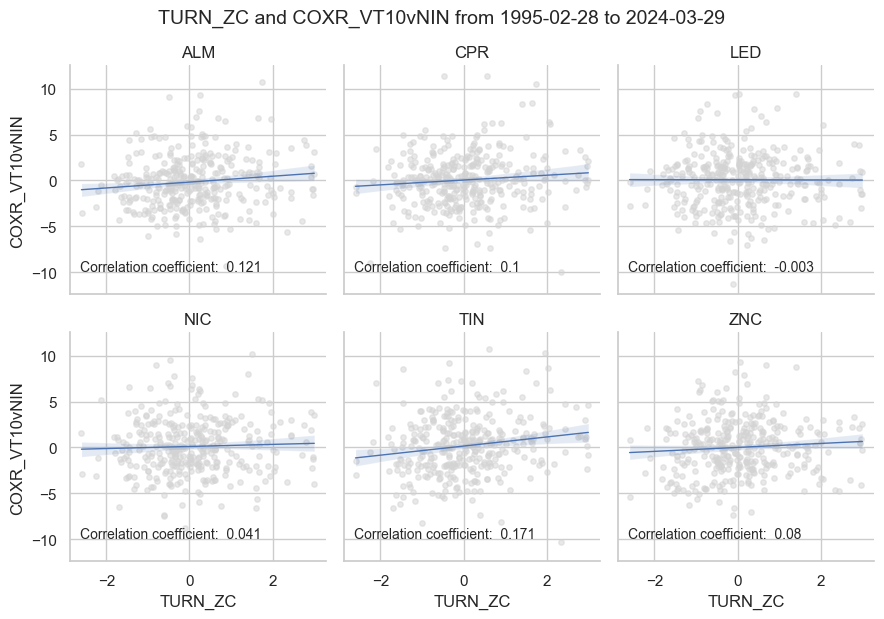

In [24]:
dix = dict_mss

df = dix["df"]
sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    df,
    xcats=[sig, targ],
    xcat1_chg=None,
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="1995-01-01",
    blacklist=blax,
    xcat_trims=[10000, 40],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    separator="cids",
    xlab=None,
    ylab=None,
    title=None,
    title_adj=1.03,
    size=(12, 6),
)

In [25]:
dix = dict_mss

df = dix["df"]
sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    df,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start="1995-01-01",
    blacklist=blax,
)

dix["srr"] = srr
srrx = dix["srr"]

The `.summary_table()` of the [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class gives a short high-level snapshot of the strength and stability of the main signal relation.

In [26]:
display(srrx.summary_table().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
Panel,0.541,0.541,0.494,0.499,0.541,0.542,0.085,0.000,0.059,0.000,0.541
Mean years,0.539,0.530,0.503,0.497,0.433,0.497,0.030,0.435,0.015,0.438,0.528
Positive ratio,0.733,0.700,0.533,0.433,0.433,0.600,0.500,0.333,0.533,0.367,0.533
Mean cids,0.541,0.541,0.494,0.499,0.541,0.542,0.085,0.271,0.058,0.275,0.542
Positive ratio,1.000,1.000,0.000,0.500,0.833,0.833,0.833,0.833,1.000,0.833,1.000


For a comparative overview of the signal-return relationship across the main and rival signals, one can use the [`signals_table`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) method.

In [27]:
display(srrx.signals_table().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
TURN_ZC,0.541,0.541,0.494,0.499,0.541,0.542,0.085,0.0,0.059,0.0,0.541
TURN_ZCX,0.538,0.538,0.465,0.499,0.539,0.536,0.089,0.0,0.058,0.0,0.537


#### PnLs

[`NaivePnl() class`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label naive because its methods do not take into account transaction costs or position limitations, such as risk management considerations. This is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations.

In [28]:
dix = dict_mss

df = dix["df"]
sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

naive_pnl = msn.NaivePnL(
    dfx_ind,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    #  bms=["USD_EQXR_NSA"],
    start="1995-01-01",
    blacklist=blax,
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        thresh=3,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="binary",
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_DIG",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="LONG")

dix["pnls"] = naive_pnl

The below chart shows the naïve PnLs for both basic strategies and a “long only” strategy, which here is a strategy that is always long the base metal contracts versus the non-industrials.

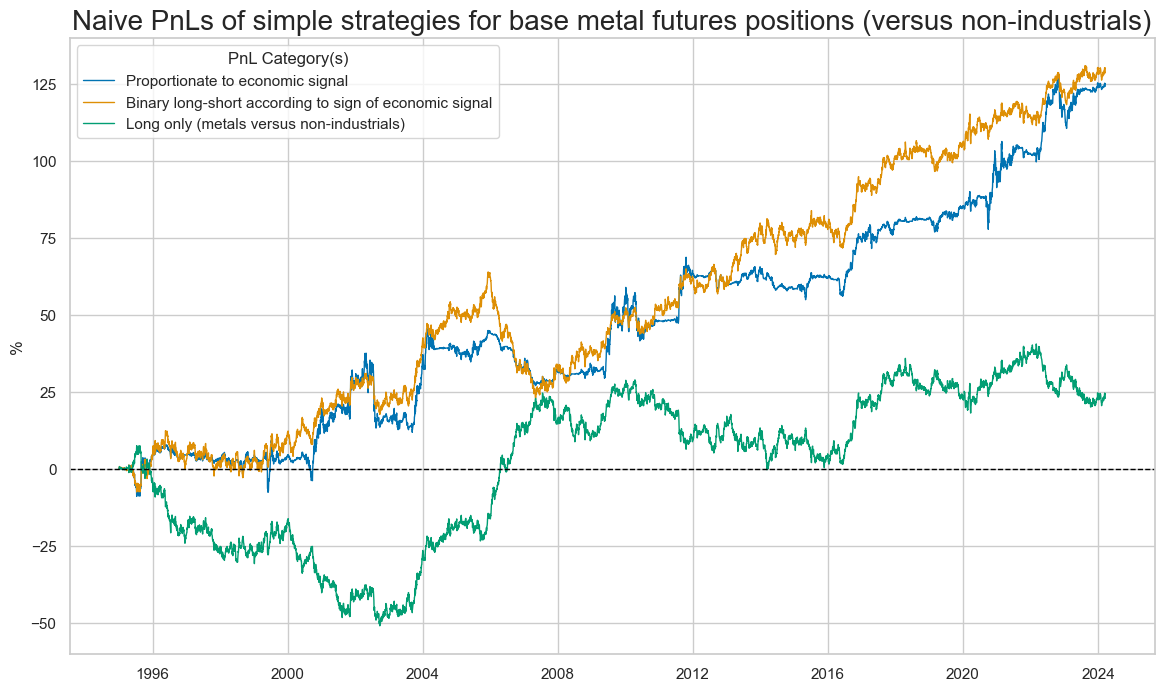

In [38]:
dix = dict_mss

sig = dix["sig"]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN", sig + "_DIG", "LONG"]

dict_labels={"TURN_ZC_PZN": "Proportionate to economic signal",
             "TURN_ZC_DIG": "Binary long-short according to sign of economic signal",
             "LONG": "Long only (metals versus non-industrials)"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="1995-01-01",
    ylab="%",
    title="Naive PnLs of simple strategies for base metal futures positions (versus non-industrials)",
    title_adj=0.8,
    xcat_labels=dict_labels,
    figsize=(14, 8),
)

In [30]:
dix = dict_mss

naive_pnl = dix["pnls"]
pnls = [dix["sig"] + "_PZN", dix["sig"] + "_DIG"]
cidx = ["ALL"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=cidx,
    start="1995-01-01",
)

The average Sharpe ratio has been just below 0.5 and the average Sortino ratio 0.6 for the period 1995 to 2023. The binary long-short strategy performed a little better. The method 'evaluate_pnls()' returns a small dataframe of key PnL statistics. 

In [31]:
display(df_eval)

xcat,TURN_ZC_DIG,TURN_ZC_PZN
Return (pct ar),4.405917,4.256629
St. Dev. (pct ar),10.0,10.0
Sharpe Ratio,0.440592,0.425663
Sortino Ratio,0.638335,0.618001
Max 21-day draw,-9.83188,-19.900901
Max 6-month draw,-19.242124,-22.349179
Traded Months,351,351


In [32]:
dix = dict_mss

naive_pnl = dix["pnls"]
pnls = [dix["sig"] + "_PZN"]
cidx = ["ALL"] + dix["cidx"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=cidx,
    start="1995-01-01",
)

The same table can be viewed by cross-sections:

In [33]:
display(df_eval)

cid,ALL,ALM,CPR,LED,NIC,TIN,ZNC
Return (pct ar),4.256629,0.846943,0.806149,0.042049,0.394863,1.572266,0.630261
St. Dev. (pct ar),10.0,2.290992,2.214692,2.336084,2.370517,2.589898,2.250156
Sharpe Ratio,0.425663,0.369684,0.364,0.018,0.166572,0.607076,0.280097
Sortino Ratio,0.618041,0.544252,0.537077,0.025767,0.239752,0.898829,0.402928
Max 21-day draw,-19.900901,-2.679935,-3.964102,-3.405405,-3.441839,-5.731117,-3.377814
Max 6-month draw,-22.349179,-4.335921,-5.143924,-6.146423,-4.666372,-5.173195,-5.565792
Traded Months,351,351,351,351,351,351,351


### Manufacturing survey changes

Here we test the predictive power of mood swings in manufacturing for subsequent monthly and quarterly metals futures excess returns (relative to non-industrial commodity returns).

In [34]:
dict_msv_st = {
    "df": dfx_ind,
    "sig": "ISMMANU_SA_D3M3ML3ZN",
    "rivs": [
        "PHILMANU_SA_D3M3ML3ZN",
    ],
    "targ": "COXR_VT10vNIN",
    "cidx": cids_ind,
    "black": coblack,
    "srr": None,
    "pnls": None,
}

ISM survey changes have displayed a positive correlation with subsequent quarterly returns of all six base metal futures. However, the strength of the correlation has been different. On a quarterly basis, it was strong for aluminum, tin, and zinc, but quite faint for nickel and lead.

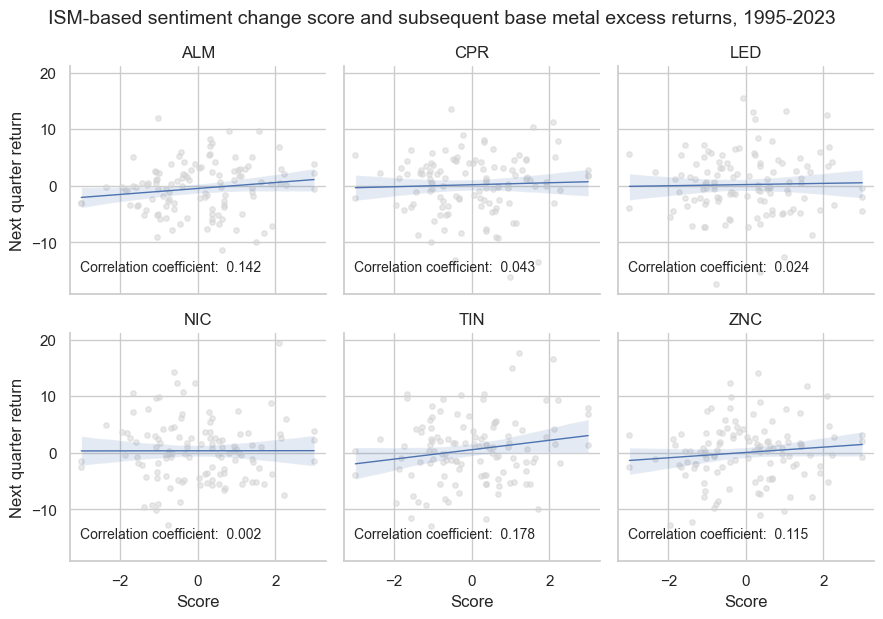

In [35]:
dix = dict_msv_st

df = dix["df"]
sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    df,
    xcats=[sig, targ],
    xcat1_chg=None,
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="1995-01-01",
    blacklist=blax,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    separator="cids",
    xlab="Score",
    ylab="Next quarter return",
    title="ISM-based sentiment change score and subsequent base metal excess returns, 1995-2023",
    title_adj=1.03,
    size=(12, 6),
)

dix["srr"] = srr

In [36]:
dix = dict_msv_st

df = dix["df"]
sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    df,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="Q",
    start="1995-01-01",
    blacklist=blax,
)

dix["srr"] = srr

For a comparative overview of the signal-return relationship across the main and rival signals, one can use the `signals_table()` method.

In [37]:
display(srr.signals_table().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
ISMMANU_SA_D3M3ML3ZN,0.509,0.508,0.509,0.514,0.523,0.494,0.083,0.028,0.038,0.138,0.508
PHILMANU_SA_D3M3ML3ZN,0.517,0.518,0.466,0.514,0.534,0.503,0.151,0.000,0.082,0.001,0.518
